# CNN on OCT-Retinal

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16

In [3]:
train_data_dir = 'OCT2017/train'
validation_data_dir = 'OCT2017/test'

In [4]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 34464 images belonging to 4 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 3223 images belonging to 4 classes.


## CNN Model

In [8]:
def cnn():
    model = Sequential([

    # 1st CONV-ReLU Layer
    Conv2D(64, (3, 3), activation="relu",padding = 'same', input_shape = (img_rows, img_cols, 3)),
    BatchNormalization(),

    # 2nd CONV-ReLU Layer
    Conv2D(64, (3, 3), activation="relu", padding = "same"),
    BatchNormalization(),

    # Max Pooling with Dropout 
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 3rd set of CONV-ReLU Layers
    Conv2D(128, (3, 3), activation="relu",padding="same"),
    BatchNormalization(),

    # 4th Set of CONV-ReLU Layers
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout 
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 5th Set of CONV-ReLU Layers
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
        
    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Final Dense Layer
    Dense(num_classes,activation="softmax"),
    ])
    return model

In [9]:
model = cnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
__________

### Training CNN Model

In [10]:
checkpoint = ModelCheckpoint("retinal_cnn1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks = [earlystop, checkpoint, reduce_lr]

In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

In [12]:
nb_train_samples = 34464
nb_validation_samples = 3223
epochs = 10

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
2154/2154 [==============================] - 718s 333ms/step - loss: 0.7794 - acc: 0.6848 - val_loss: 0.7234 - val_acc: 0.7264

Epoch 00001: val_loss improved from inf to 0.72339, saving model to retinal_cnn1.h5
Epoch 2/10
2154/2154 [==============================] - 739s 343ms/step - loss: 0.4036 - acc: 0.8554 - val_loss: 0.2873 - val_acc: 0.9033

Epoch 00002: val_loss improved from 0.72339 to 0.28732, saving model to retinal_cnn1.h5
Epoch 3/10
2154/2154 [==============================] - 741s 344ms/step - loss: 0.3335 - acc: 0.8833 - val_loss: 0.8097 - val_acc: 0.7711

Epoch 00003: val_loss did not improve from 0.28732
Epoch 4/10
2154/2154 [==============================] - 732s 340ms/step - loss: 0.3073 - acc: 0.8903 - val_loss: 0.2099 - val_acc: 0.9267

Epoch 00004: val_loss improved from 0.28732 to 0.20989, saving model to retinal_cnn1.h5
Epoch 5/10
2154/2154 [==============================] - 743s 345ms/step - loss: 0.2857 - acc: 0.9007 - val_loss: 0.6742 - val_acc: 0.

In [14]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

202/202 [==============================] - 20s 99ms/step

Test result: 94.446 loss: 0.163


In [15]:
model.save("retinal_cnn.h5")

## Confusion Matrix 

In [14]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 3223 images belonging to 4 classes.


In [15]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [16]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

In [17]:
y_pred_label = np.argmax(y_pred, axis=1)

In [18]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[221  14   7   0]
 [ 31 876  15  77]
 [ 12   2 937  32]
 [  2  31  12 954]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.83      0.91      0.87       242
         DME       0.95      0.88      0.91       999
      DRUSEN       0.96      0.95      0.96       983
      NORMAL       0.90      0.95      0.93       999

   micro avg       0.93      0.93      0.93      3223
   macro avg       0.91      0.92      0.92      3223
weighted avg       0.93      0.93      0.93      3223



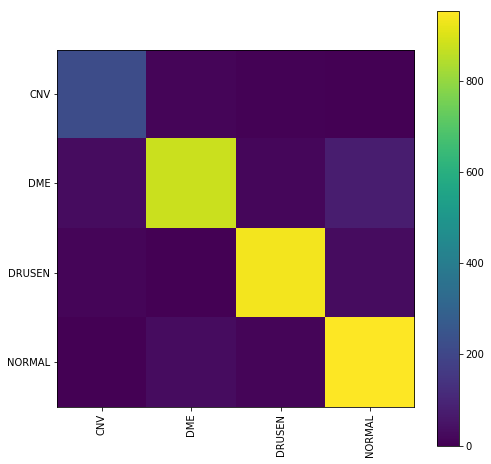

In [19]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

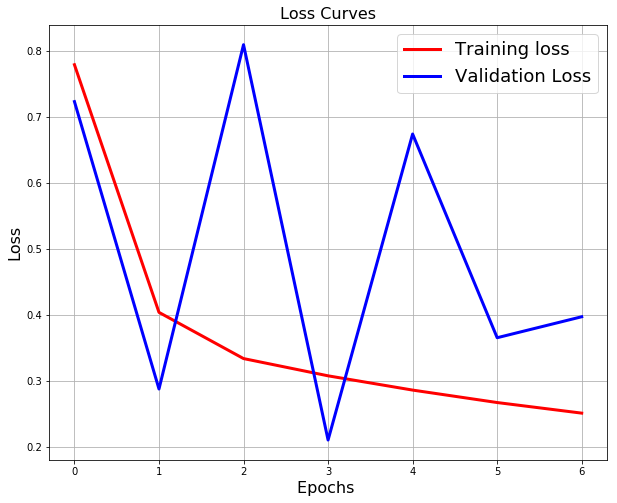

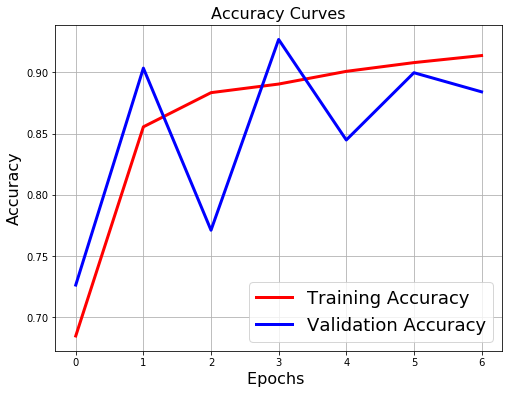

In [20]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Loading saved classifier

In [21]:
classifier = load_model('retinal_vgg.h5')

## Testing on Images

In [22]:
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)
    

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = 'OCT2017/val/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, (img_width, img_height), fx=5, fy=5, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

<img src="OCT-Retinal-VGG.png">

### Model Plot

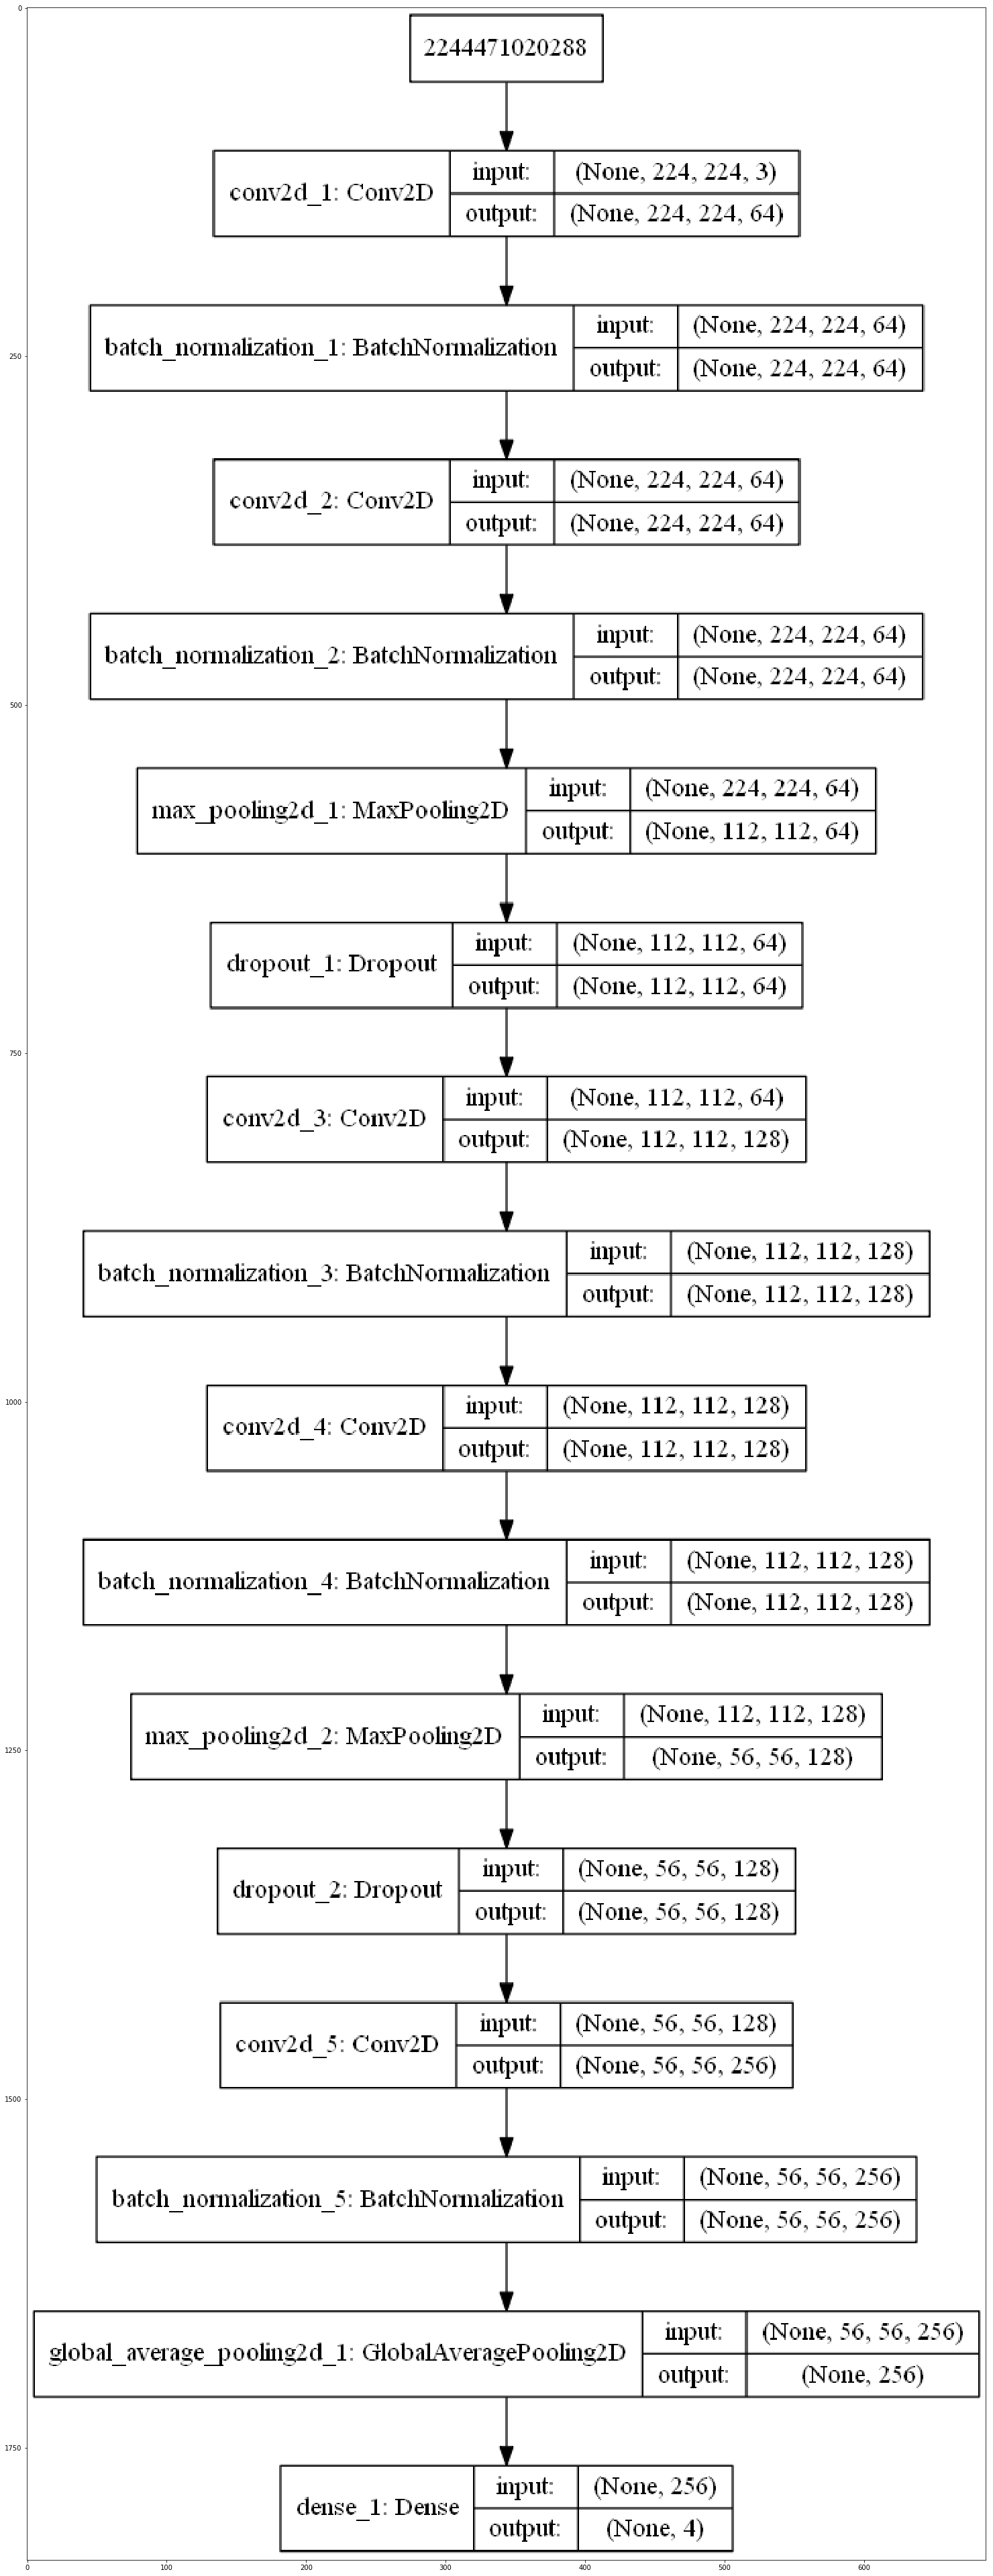

In [23]:
plot_model(model, to_file='model_plot_retinal_cnn.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_plot_retinal_cnn.png')
plt.figure(figsize=(100,70))
imgplot = plt.imshow(img)